# Homework Assignment 1 : Understanding Bias-Variance Tradeoff
---
---

YOU MUST NOT MAKE CHANGES TO THIS DOCUMENT - IT WILL NOT BE SAVED. INSTEAD, MAKE A COPY OF THIS NOTEBOOK AND PLAY AROUND WITH IT THERE.

Go Here: ```File --> Save a copy in Drive```

You can use this notebook as a point of reference and submit your own code as well. 

In [323]:
# @title Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import neighbors, datasets
from sklearn.linear_model import LinearRegression #regression
from sklearn.neighbors import KNeighborsRegressor #KNN
from sklearn.model_selection import train_test_split #splitting data into train and test sets
from sklearn import datasets #importing dummy data 
from sklearn.metrics import mean_squared_error # to measure the error between predicted value and actual value

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.datasets import load_iris

#======== added imports ===============
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

In [325]:
# @title Helper Functions: Data Generation
def get_points(set_type="exponential", num_points=200):
  """
  Function to generate data according to some chosen function (or distribution).
  params:
    set_type (string) : indicates the type of function you wish to generate points from.
                        this can be one of "exponential", "line", "polynomial-n", "sine", "cosine", 
    num_points (int)  : parameter to set the number of points you want to generate. 

  returns:
    x (np.array)      : input space
    y (np.array)      : f(x) -> this is your oracle labeller function
  """

  # initializing
  x = np.linspace(0.1,1 , num_points) # CHANGE DOMAIN HERE if you use log/inverse function domain should not contain 0
  y = np.zeros_like(x)

  if set_type == "line":
    # points from a line of the form y = m*x + c
    # change m, c to generate different lines
    m, c = 0.45, 2 # CHANGE HERE
    y = m * x + c  
  
  elif set_type == "exponential":
    # generates points from an exponential of the form y = a + b*exp(x)
    # change a, b to generate a different exponential
    a, b = 2, 3 # CHANGE HERE
    y = a * np.exp(x)

  elif set_type == "sine":
    # generates points from an exponential of the form y = a + b*sin(x)
    # change a, b to generate different sine wave
    a, b = 2, 3 # CHANGE HERE
    y = a + b * np.sin(x)
      
  elif set_type == "cosine":
    # generates points from an exponential of the form y = a + b*cos(x)
    # change a, b to generate different cosine wave
    a, b = 2, 3 # CHANGE HERE
    y = a + b * np.cos(x)   

  elif set_type == "polynomial-n":
    # generates points from a degree n polynomial of the form 
    # y = a_0 + a_1*x + a_2*x^2 + ... + a_(n-1)*x^(n-1)
    
    np.random.seed(2021) # CHANGE RANDOM SEED TO SET DIFFERENT COEFFS
    n = 7 # CHANGE DEGREE OF POLYNOMIAL HERE
    coeffs = 3 * np.random.random_sample(n) # [a_(n-1), a_(n-2),..., a_2, a_1, a_0]
    y = np.polyval(coeffs, x)  


  #========= Added Function (tan, log, inverse) ======================= 

  elif set_type == "tangent":
    # generates points from an exponential of the form y = a + b*tan(x)
    # change a, b to generate different cosine wave
    a, b = 2, 3 # CHANGE HERE
    y = a + b * np.tan(x) 

  elif set_type == "log":
    # generates points from an exponential of the form y = a + b*tan(x)
    # change a, b to generate different cosine wave
    a = 1 # CHANGE HERE
    y = a + np.log2(x)    #domain of x needs to be changed such that 0 is not included

  elif set_type == "inverse":
    # generates points from an inverse function of the form y = a/x
    # change a to generate different cosine wave
    a = 1   #change here
    y = a/x  # domain of x needs to be changes such the 0 is not included

  #========= Added Function (tan, log, inverse) ======================= 

  else:
    raise Exception("Invalid argument to set_type.")

  # print(x.shape, y.shape) # always check shapes
  return x, y

#--------------------------------------------------------------------------------------------------------

def get_noise(num_points=200):
  """
  Function to generate noise from a standard normal distribution.
  params: 
    num_points (int) : number of points generated. 
  
  returns: 
    a numpy array of size num_points populated with samples from a standard normal distribution
  """
  np.random.seed(2021)
  return np.random.normal(loc = 0.0, scale = 1, size = num_points)

#--------------------------------------------------------------------------------------------------------
  

def generate_noisy_data(x, y, noise):
  """
  Function to add noise to the generated points. 
  params: 
    x, y (np.arrays) : points obtained using get_points() with a fixed num_points
    noise (np.array)  : points obtained using get_noise() with the same num_points as above

  returns:
    data (np.array)   : noisy data, array of size num_points

  """
  assert x.shape[0] == y.shape[0] == noise.shape[0], "number of elements in 'x', 'y' and 'noise' arrays do not match"

  y_ = y + noise

  # uncomment to plot your data before and after adding noise
  plt.figure(figsize=(15,8))
  plt.plot(x, y)
  plt.plot(x, y_)

  data = (x, y_)
  # print(data.shape) # always check shapes

  return data

  #--------------------------------------------------------------------------------------------------------



## Data Generation
In class, we saw the importance of knowing where our data comes from. All our learning problems would cease to exist if we figured out the true distribution of the events in the world around us. In real life scenarios, we rarely have access to the full distribution of data. However, to study how learning algorithms perform on different learning tasks, we can generate some data and *pretend*  like we do not know anything about the data we have generated. And in continuation with the game of pretence, we will also try to *model* this data, to try and understand everything about it. The advantage here? Since we have access to the truth (since we generated the data, and thus we're the oracle too), we can evaluate how our learner performs. 

\\

Now, for the **first step: generating data**. Above, we have provided a few helper functions for you that allow you to generate data points from various numerical functions. You have ample legroom to change the parameters, so feel free to experiment. Add your own generation models too, if you want to. **You should experiment with "line", "exponential" and "polynomial-n" at least for full points. The rest (and any other function experimented with will give you bonus points). After generating the data, fitting a model and estimating performance, you must put in your observations, backed by plots, into a pdf document and briefly explain what you observe in words.**

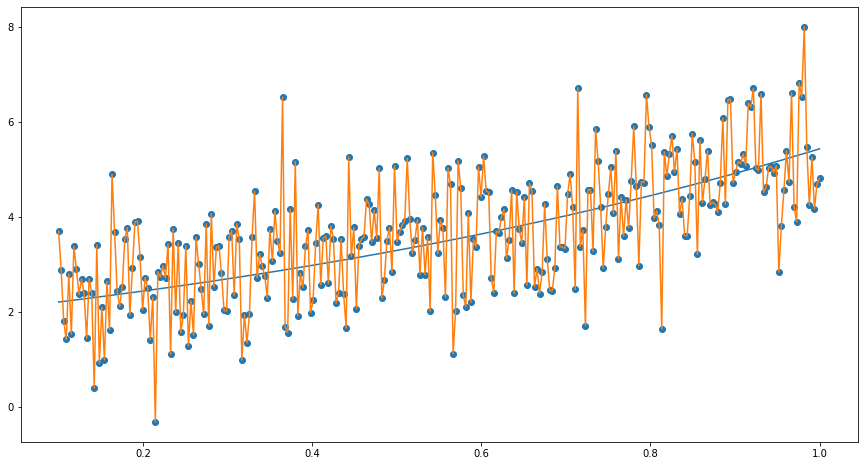

In [326]:
# SET YOUR GLOBAL PARAMS FOR DATA GENERATION HERE
num_points = 300 # number of data points
set_type = "exponential"  # the function you want to simulate if you use log or inverse pls change the domain such that 0 is not included

# use the above functions to 
#   1. get points in the x, y plane according to a function of your choice
#   2. generate noise
#   3. add the two together to generate a dataset

# YOUR CODE GOES HERE
x, y = get_points(set_type,num_points)
noise = get_noise(num_points)
data = generate_noisy_data(x,y,noise)

# uncomment to see the final plot

plt.scatter(data[0], data[1]) # clearly, data[0] = x, data[1] = y


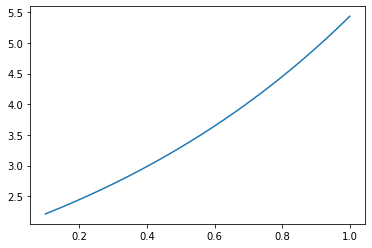

In [327]:
plt.plot(x,y)

You have successfully generated data!

\\
Now, we move on to **sampling**. Let's make the story clear again: We've generated some data according to some underlying rule, but going forward, we pretend we can only sample from this data, that is, **our window to this world are the small samples we can draw**. 

You can set the sample size below, and the number of samples you want to draw from the data. What you see below is in some senses, also called bootstrapping (we're sure you'll look it up.)

In [328]:
#@title Helper Functions : Sampling, Test-Train Split
def sampler(data_df, sample_size):
  """
  function to sample 'sample_size' number of elements from the passed dataframe
  params:
    data_df (pandas dataframe) : contains the data we generated, with x, y as columns
    sample_size (int)          : indicates the number of samples we wish to pick for the set you want to pick

  returns:
    sample_set (pandas df)     : dataframe of the sample set, with x, y as columns
  """

  sample_set = data_df.sample(n = sample_size).reset_index(drop="True")
  return sample_set

def split(sample_set, fraction = 0.8):
  """
  function that takes a sample set and returns test and train sets split according 
  to a set fraction. Default split -> test:train :: 20:80

  params: 
    sample_set (pd dataframe) : contains x, y as columns respectively 
    fraction  (float)         : specifies the fraction of samples you want in the test set

  returns:
    a tuple (train_set, test_set)
  """
  # sample_set_shuffled = sample_set.iloc[np.random.permutation(sample_set.index)].reset_index(drop=True)
  # print(sample_set_shuffled)
  # test_set = sample_set_shuffled.sample(frac=fraction).reset_index(drop=True)
  # train_set = sample_set_shuffled.drop(test_set).reset_index(drop=True)

  train_set, test_set = train_test_split(sample_set, test_size=fraction)

  return train_set, test_set

## Sampling

Use the helper functions given above to draw sample sets of a fixed size from your generated data. Once you finish that, your sample sets will be stored in a list named ``` sample_sets ``` and you can access individual sets using the syntax ```sample_sets[i]```. Feel free to add a few code cells and see what your sample sets look like. 



In [329]:
# SET PARAMS FOR SAMPLING HERE
sample_size = 100 # the number of samples you want to draw.
num_sample_sets = 2 # the number of sets you want to create, each with 'sample_size' elements

# making a dataframe out of data
data = pd.DataFrame(data).transpose()

# store all your samples in this list
sample_sets = list()
for i in range(num_sample_sets):
  #run sampler() on data to collect sample_size samples in each iteration
  df = sampler(data, sample_size)
  sample_sets.append(df)
print(sample_sets)

[           0         1
0   0.208361  1.418572
1   0.774247  3.777237
2   0.993980  4.177417
3   0.503344  3.690446
4   0.184281  1.932523
..       ...       ...
95  0.765217  4.417673
96  0.635786  4.570104
97  0.650836  4.415629
98  0.238462  1.992932
99  0.319732  1.944649

[100 rows x 2 columns],            0         1
0   0.500334  3.479475
1   0.151171  2.101309
2   0.367893  1.688154
3   0.139130  2.401299
4   0.115050  1.538355
..       ...       ...
95  0.352843  3.071159
96  0.915719  6.397920
97  0.843478  3.608667
98  0.912709  5.082691
99  0.419064  2.605692

[100 rows x 2 columns]]


We have given you some custom functions to split your individual sample sets into testing and training sets. Below, you can choose to play around with these functions or use the methods shown in the following section to create test and train sets. Our data is stored as points on the $2$-$D$ plane, so we need to separate out the inputs (**x**, or sometimes **X**) and the labels (**y**) for each set. 

In [330]:
# SET PARAMS FOR SPLIT HERE
fraction = 0.2
sample_set = sample_sets[0] #eg: sample_sets[1]

train_set, test_set = split(sample_set, fraction)
# x_train, y_train = train_set[0], train_set[1] --> convert these to numpy arrays
# x_test, y_test = test_set[0], test_set[1]
print("Size Train set: {}".format(train_set.shape))
print("Size Test set: {}".format(test_set.shape))

Size Train set: (80, 2)
Size Test set: (20, 2)


## Regression
---

In the previous sections, we generated and sampled from data. Now, we get to the actual fun part, where we try to 'fit' a model to the data. What do we mean by this? Think about the PAC learning scenario you were introduced to in class.

\\
As far as we are concerned, the training data is the only thing our learner has access to. It learns about the underlying data distribution based on this, or forms hypotheses about what the labelling function is.  The learner will try to minimize "empirical" or observable risk (a.k.a the training error) using a hypothesis it has formed on the sample available to it. Now is a good time to refelct on what you learnt about good and bad sample sets, and how this can affect training. 

As an external jury, when we want to see how well our model is able to "generalize" to data it has never seen before, we use the test set. This evaluation will give you an idea about whether or not your learner has hypothesised a function that fits supremely to the training set but atrociously to anything else, or performs well in either case, or any variation in between. 

---
The learning model you will be using in the following section is **Regression**. We have performed regression below on a dummy dataset so that you can get a taste of how the functions need to be used. **Your task is to use the data you generated above, and perform regression analyses with varying parameters, on each kind of dataset, and write a detailed report of your observations, backed by plots.** When do you see the model perform best on the training set? Does that automatically mean it performs best on the test set? Are there any assumptions we are implicitly making about the test and training data and how do you think it affects the model's performance overall? 

In [331]:
# @title Helper Function: Regression
# @markdown These functions just provide one way  and it is not mandatory to use (you can define your own).

# def linear_reg(X_train,y_train,X_test,y_test):
#   '''
#   Implementing linear regression using the Sci-kit learn module.
#   This function takes in the following parameters:
#   X_train,y_train : (Input,Output) pairs, on which we fit a regression model
#   X_test,y_test   : (Input,Output) pairs unseen by the model which help us evaluate its performance
#   '''  
#   reg = LinearRegression().fit(X_train, y_train) #fitting the linear regression model
#   y_pred = reg.predict(X_test) # predicting the output on the basis of unseen inputs
#   error = mean_squared_error(y_test, y_pred)
#   print("Prediction Error: {}" .format(error))


#   #training error
#   train_pred = reg.predict(X_train)
#   train_error = mean_squared_error(y_train,train_pred)
#   print("Training Error: {}" .format(train_error))
#   # plt.style.use("ggplot")
#   # plt.scatter(X_test, y_test,label='data') #plotting the test data
  
#   # plt.show()

#   # plt.scatter(X_test,y_pred)
#   y = max(y_test)
#   y_= min(y_test)
#   x = np.linspace(y_,y,1000)
#   plt.figure(figsize=(15,10))
#   plt.scatter(y_test,y_pred)
#   # plt.plot(X_test, y_pred,label='prediction',color="purple")   #plotting the curve using our predictions

#   # plt.plot(x,x,"g")
#   plt.xlabel("Actual Value")
#   plt.ylabel("Predicted Value")
#   plt.title("Actual Vs Predicted values ({} function)".format(set_type))
#   plt.show()

# linear_reg(train_set[0].values.reshape(-1,1), train_set[1], test_set[0].values.reshape(-1,1), test_set[1])

(37.836665828460795, 0.4815483021897332)

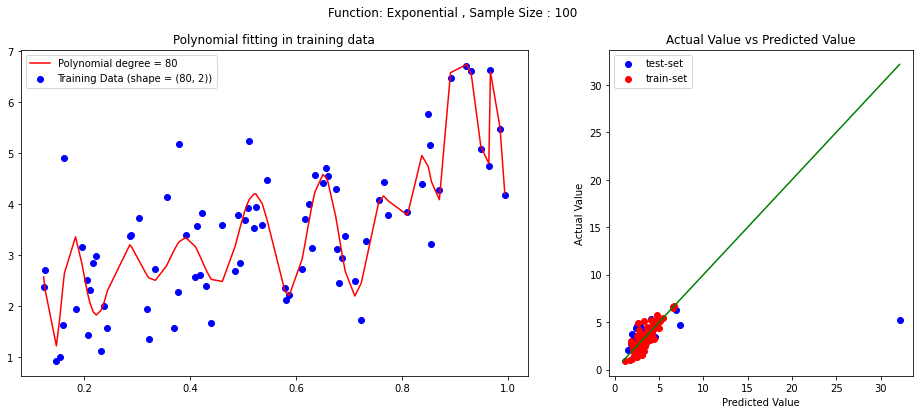

In [332]:
### Polymonial Regression

def poly_reg(degree, x_train, y_train, x_test, y_test):
	'''
	function: poly_reg (Gives the polynomial regression for a set of data)
		Using PolymnomialFeatures and LinearRegression functions, fits a polynomial of degree n.  

		parm: 
			1> degree: degree of the polynomial you want to fit
			2> x_train, y_train : training dataset
			3> x_test, y_test: testing dataset
		
		retun: 
			1> training error and testing error
		
		Note: This function will also plot n = degree number of plots
	'''
	
	poly_features = PolynomialFeatures(degree)

	poly_x_train = poly_features.fit_transform(x_train)
	poly_x_test = poly_features.fit_transform(x_test)

	poly_model = LinearRegression().fit(poly_x_train, y_train)

	y_test_pred = poly_model.predict(poly_x_test)  # predicting h(test_data)
	y_train_pred = poly_model.predict(poly_x_train)  #predicting h(training_data)

	test_error = mean_squared_error(y_test, y_test_pred)
	training_error = mean_squared_error(y_train, y_train_pred)


	#@Plotting
	'''
		1> Fitting polynomial on testing data: Gives an idea of overfitting and overfitting
		2> Actual value (y_test) vs Predicted Value (y_test_pred): Gives and idea of bias and vairance
		
	'''
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [5, 3]})
	fig.suptitle('Function: {} , Sample Size : {}'.format(set_type.capitalize(), sample_size))
	
	# plotting 1
	#plotting training data 
	ax1.scatter(x_train, y_train, label = "Training Data (shape = {})".format(train_set.shape), color='b')
	ax1.legend(loc='upper right')

	#plotting prediction function h(x) note: the predicted values need to be in ascending order
	x_test_1d = np.ravel(x_train)   #convertin 2d array of x_test to 1d array
	df = pd.DataFrame({"x_test": x_test_1d, "y_test_pred": y_train_pred})
	df.sort_values(by=["x_test"], inplace = True)

	ax1.plot(df.x_test, df.y_test_pred, label = "Polynomial degree = {}".format(degree), color='r')
	ax1.legend(loc='upper left')
	ax1.set_title("Polynomial fitting in training data")

	#Poltting 2
	ax2.scatter(y_test_pred, y_test, color='b', label="test-set")
	ax2.scatter(y_train_pred, y_train, color='r', label="train-set")
	ax2.set_xlabel("Predicted Value")
	ax2.set_ylabel("Actual Value")
	
	# plotting line y = x
	y = max(max(y_test),max(y_test_pred), max(y_train), max(y_train_pred))
	y_= min(min(y_test), min(y_test_pred), min(y_train), min(y_train_pred))
	x = np.linspace(y_,y,1000)
	ax2.plot(x,x, color = "g")

	ax2.set_title("Actual Value vs Predicted Value")
	ax2.legend()


	
	# print(df)
	return test_error, training_error


poly_reg(degree=80, x_train=train_set[0].values.reshape(-1,1), y_train=train_set[1], x_test=test_set[0].values.reshape(-1,1), y_test=test_set[1])

,degree,test_error,training_error
0,1.0,0.395761,1.011660
1,2.0,0.351211,0.979321
2,3.0,0.428758,0.952198
3,4.0,0.427760,0.952194
4,5.0,0.526559,0.894770
5,6.0,0.580045,0.850787
6,7.0,0.601338,0.834630
7,8.0,0.601532,0.834624
8,9.0,0.613586,0.834203
9,10.0,0.623242,0.833203


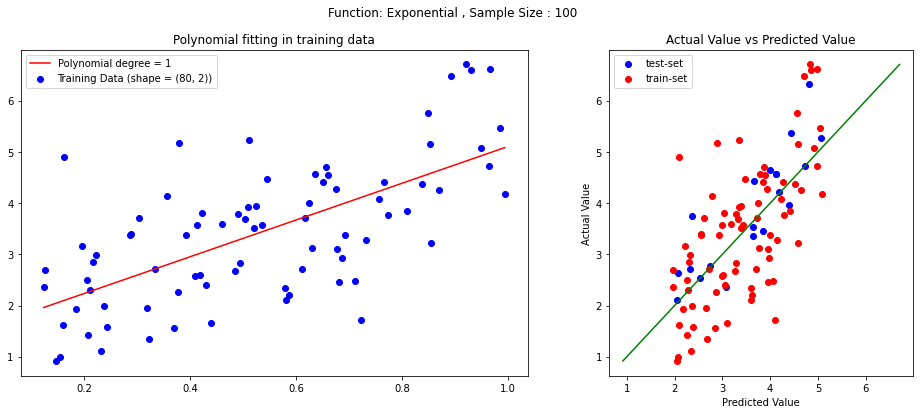

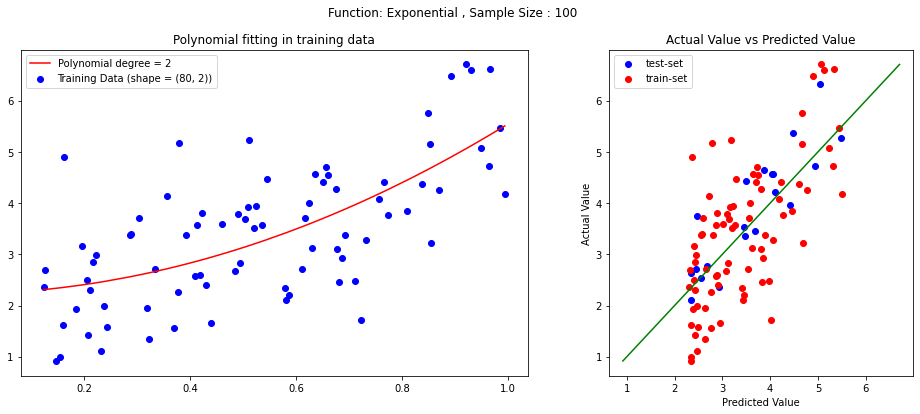

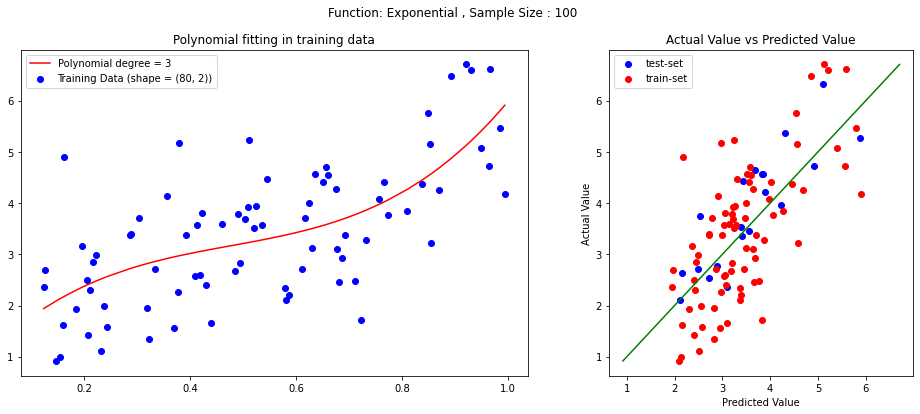

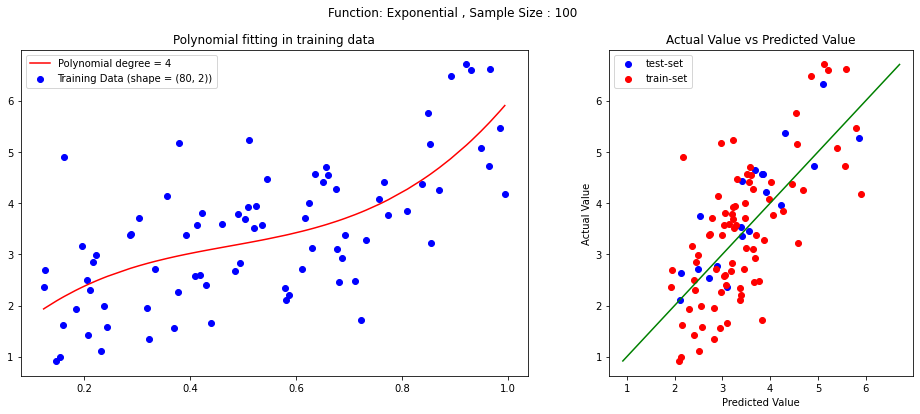

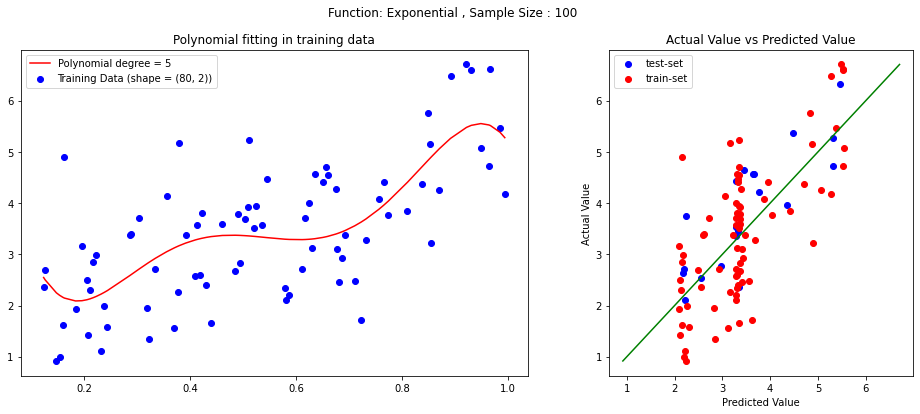

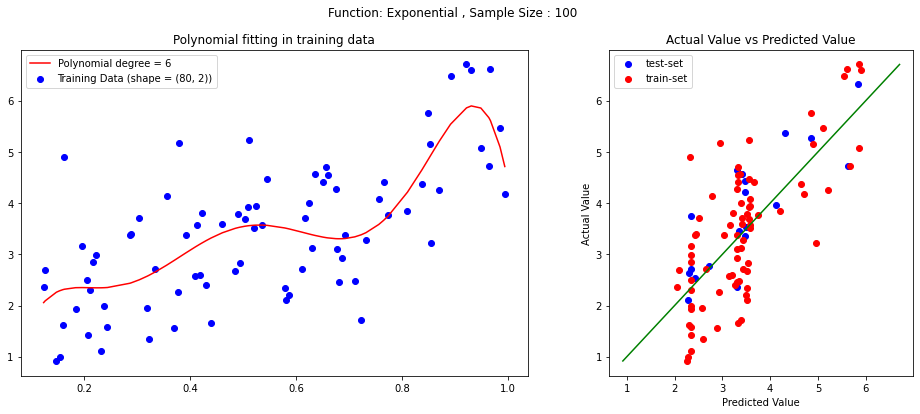

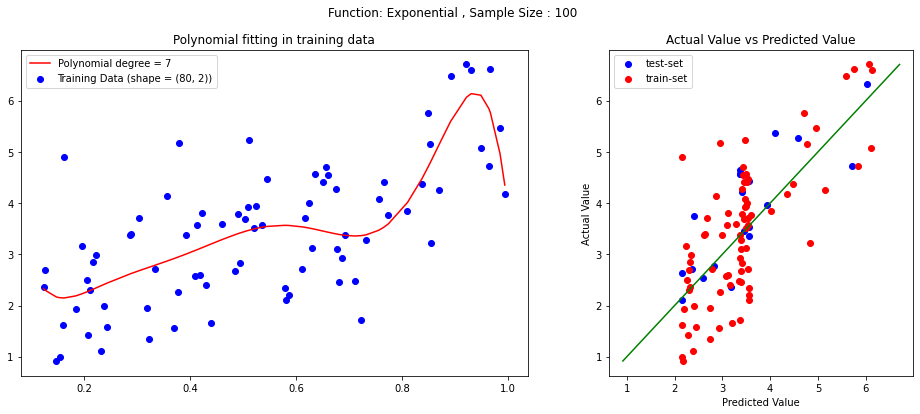

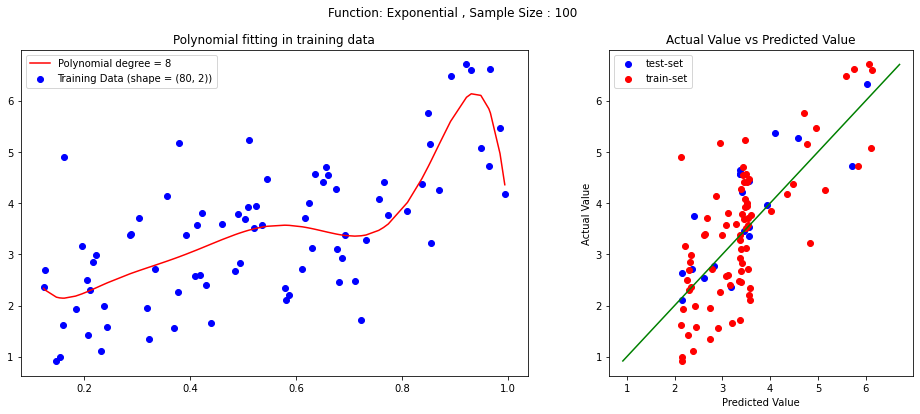

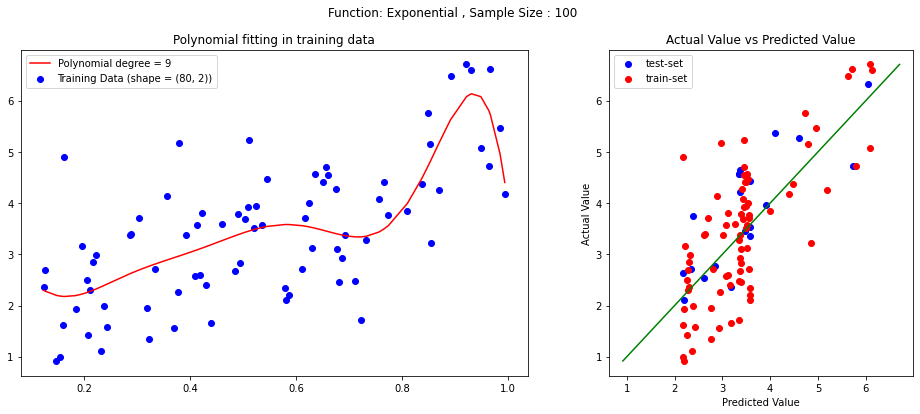

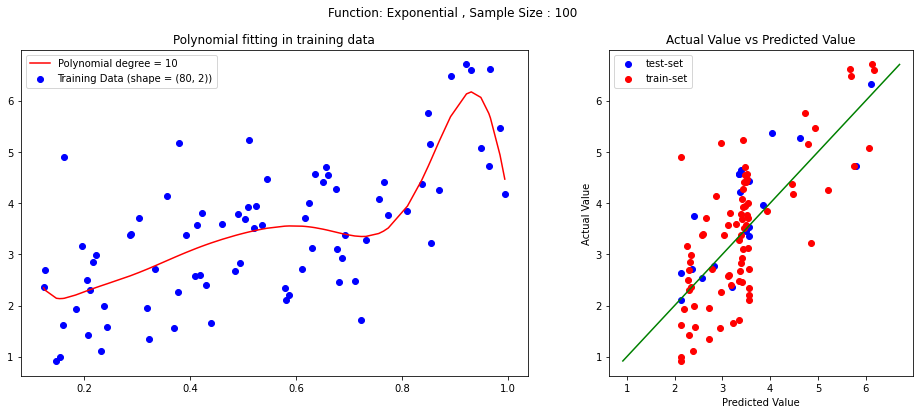

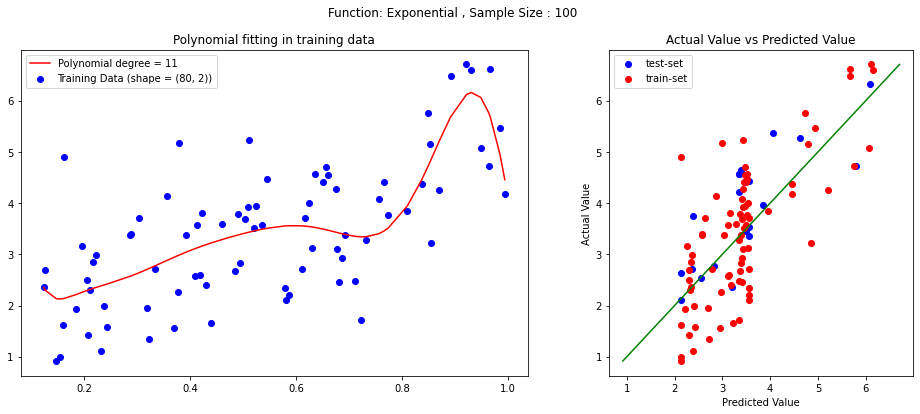

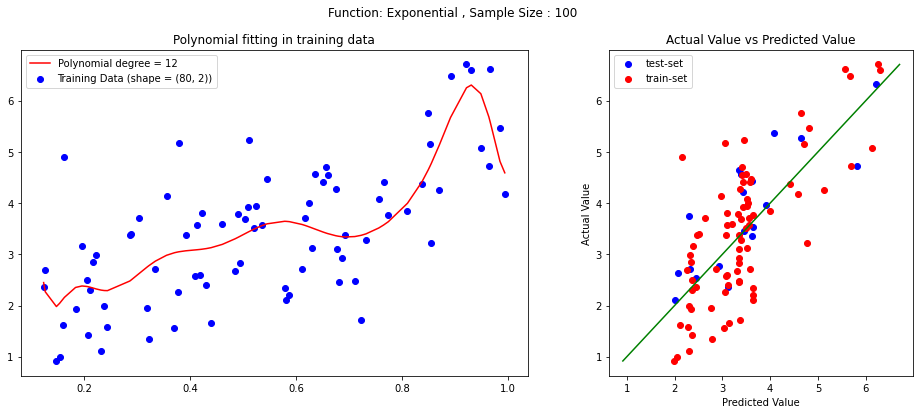

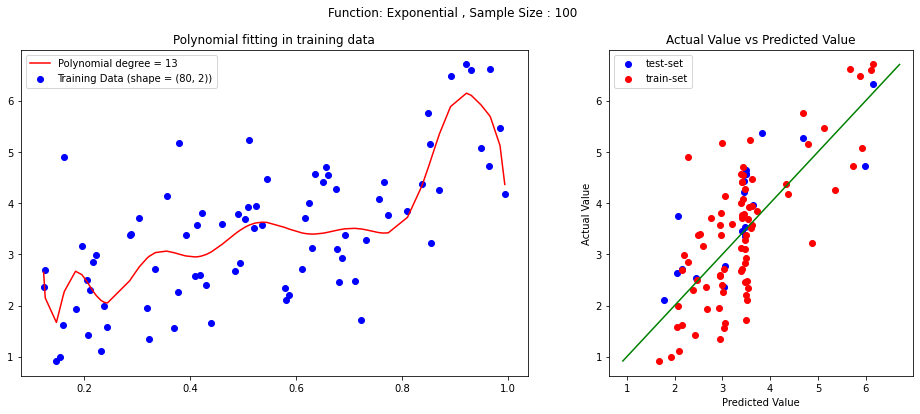

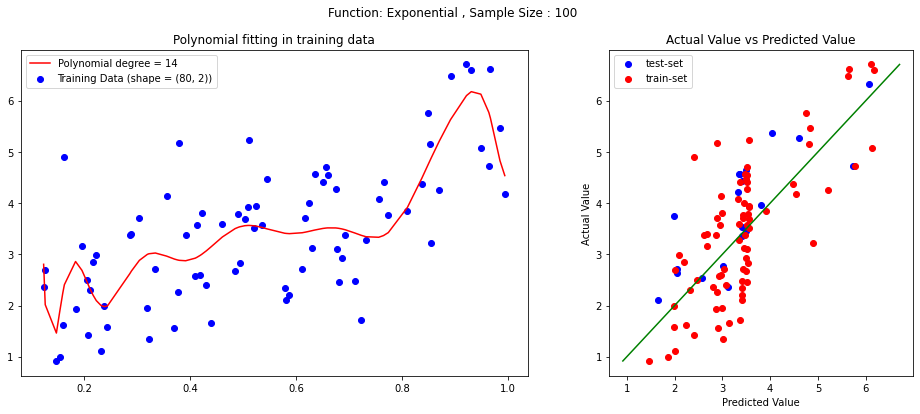

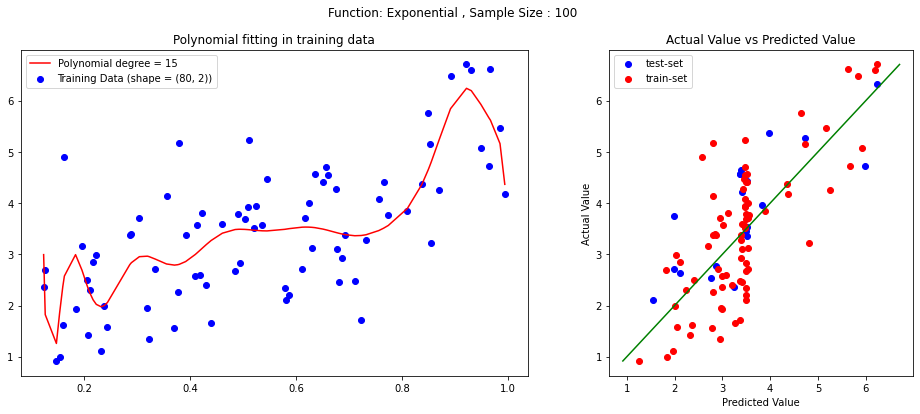

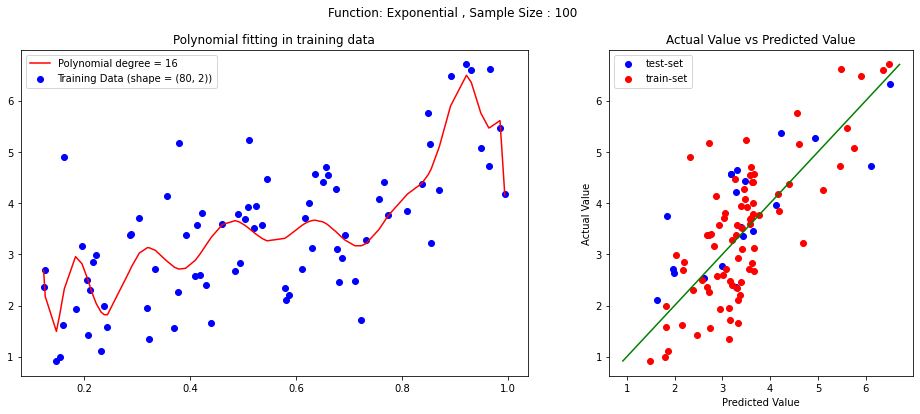

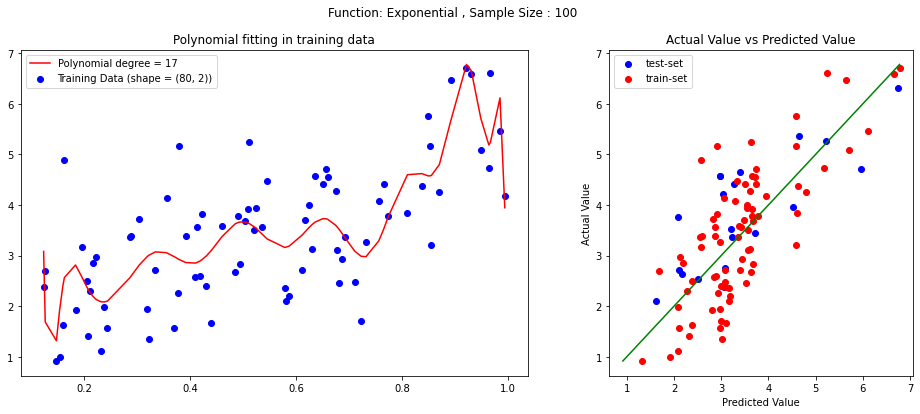

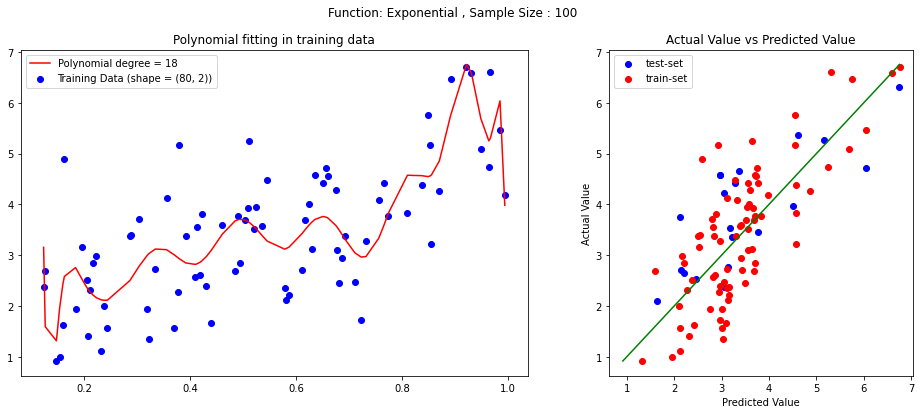

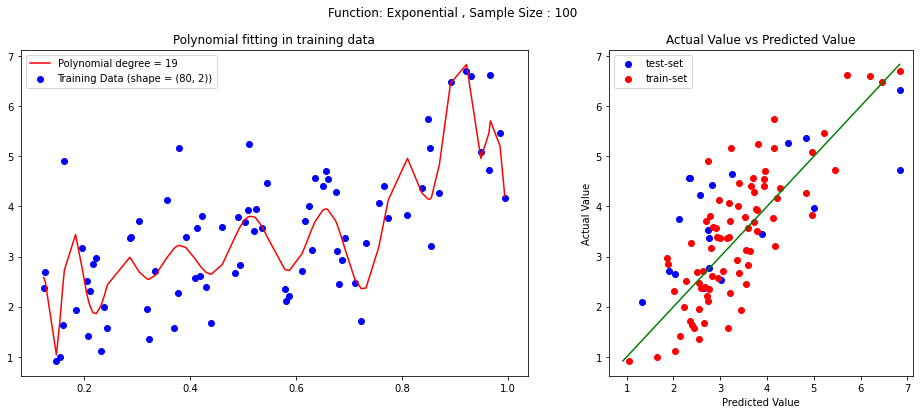

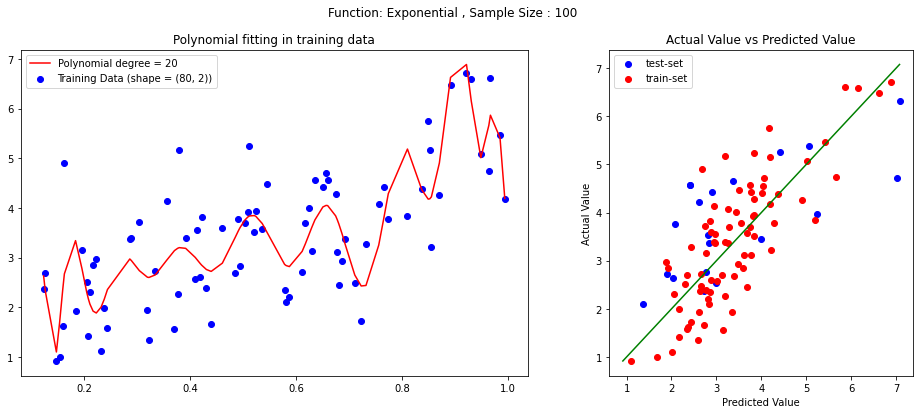

In [333]:
#creating a dataframe for test error and training error with respect to a degree 
error_df = pd.DataFrame(columns=["degree", "test_error", "training_error"])

# running poly_reg for degree i: from 1 to 20 
# Note: You are expected to get plots for each degree, if range is (1,21), 20 plots will be generated
for i in range(1,21):
	test_error, training_error = poly_reg(degree=i, x_train=train_set[0].values.reshape(-1,1), y_train=train_set[1], x_test=test_set[0].values.reshape(-1,1), y_test=test_set[1])
	error_df.loc[i-1] = [i,test_error,training_error]

error_df


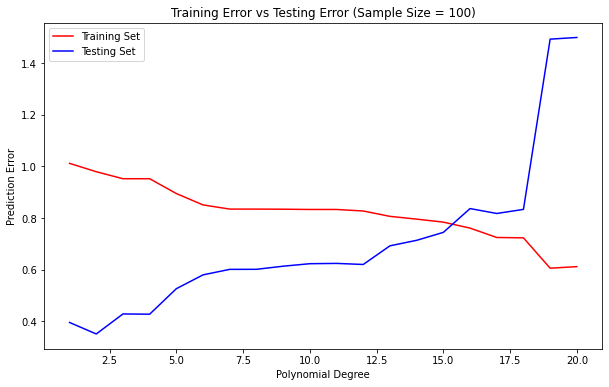

In [334]:
# Plotting the training error and testing error 
plt.figure(figsize=(10,6))
plt.plot( error_df.degree,error_df.training_error,label='Training Set',color = 'r' )

plt.plot( error_df.degree,error_df.test_error,label='Testing Set',color = 'b' )
plt.title("Training Error vs Testing Error (Sample Size = {})".format(sample_size))
plt.xlabel("Polynomial Degree")
plt.ylabel("Prediction Error")
plt.legend()

---
## K-Nearest Neighbours

We look at a **multi-class classificaltion** problem next. For this, we use an algorithm called **K-Nearest Neighbours**. Different learning problems require different approaches to find meaningful hypothesis. For instance, if you use KNN on the data generated above, it would be meaningless, since we did not define any classes of data. You could try to apply it on the sets you generated there, and see for yourself the results. 

For this task, we use the **Iris dataset**, which allows for a multi-class classification problem. 
Your task here is similar to the one above, where you vary the parameters of this model and see how it performs. Repeat the steps in the previous section. Figure out how to sample from the given dataset without using library functions. 

In [335]:
# @title Helper Functions: K-NN Clustering

# def knn(n):

#   iris = datasets.load_iris()
#   X = iris.data[:, :2] # we only take the first two features. you can try it with more, but the visualization won't be 2d anymore
#   Y = iris.target


#   h = .02 # step size in the mesh

#   knn=neighbors.KNeighborsClassifier(n_neighbors=n)

#   # we create an instance of Neighbours Classifier and fit the data.
#   knn.fit(X, Y)

#   # Plot the decision boundary. For that, we will asign a color to each
#   # point in the mesh [x_min, m_max]x[y_min, y_max].
#   x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
#   y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
#   xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#   Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
#   print(Z)

#   # Put the result into a color plot
#   Z = Z.reshape(xx.shape)
#   plt.style.use('ggplot')
#   plt.figure(1, figsize=(12, 9))
#   plt.set_cmap('BuPu')
#   plt.pcolormesh(xx, yy, Z)

#   # pltot also the training points
#   plt.scatter(X[:,0], X[:,1],c=Y,facecolors='none', edgecolors='r')
#   plt.xlabel('Sepal length')
#   plt.ylabel('Sepal width')

#   plt.xlim(xx.min(), xx.max())
#   plt.ylim(yy.min(), yy.max())
#   plt.xticks(())
#   plt.yticks(())
#   plt.show()


In [336]:
# @title Run this widget to vary the k in the model and visualize what it does.
# interact(knn, n=widgets.IntSlider(min=5, max=50, step=1, value=5))b

### Sampling the data

In [337]:
#sampling the data
import random
num_sets = 2 #change here
knn_sample_size = 70  #change here

#Loading the iris dataset and splitting the data using the train_test_split function
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features. you can try it with more, but the visualization won't be 2d anymore
Y = iris.target

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#sampling part
#takes the XY appended array
#returns the sample sets
def sampling(XY_arr):
	sample_sets = []
	for i in range(num_sets):
		buffer_set = []
		while len(buffer_set) != knn_sample_size:
			r = random.randint(0,len(XY_arr)-1)
			buffer_set.append(XY_arr[r])
			XY_arr = np.delete(XY_arr,r,0)
		sample_sets.append(buffer_set)
	return sample_sets

#concatenate x and y to a single array
XY_arr = []
counter = 0
for lists in X.tolist():
	lists.append(Y[counter])
	counter += 1
	XY_arr.append(lists)

XY_arr = np.array(XY_arr)


sample_sets = sampling(XY_arr)


In [338]:
choose_sample = np.array(sample_sets[1])  #change 0 to any sample set
x_sampled = choose_sample[:,:2]
y_sampled = choose_sample[:,2:3].ravel()

#splitting the sampled x and y into training and testing set

X_train, X_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size = 0.2)


### Implementing Knn with the help of the helper function provided above. 
### Error defined as average error can be experimented with mse an accuracy score


In [339]:
# h = .02 # step size in the mesh

def knn_error(n, X_train, X_test, y_train, y_test ):

	'''
	function same as above
	'''
	knn=neighbors.KNeighborsClassifier(n)

	# we create an instance of Neighbours Classifier and fit the data.
	knn.fit(X_train, y_train)

	y_test_predict = knn.predict(X_test)  #error with y_test
	y_train_predict = knn.predict(X_train) #error with y_train

	return y_train, y_train_predict, y_test, y_test_predict

def get_error(real_arr, predict_arr):
	'''
	function: get_error

	parms: 
		1> real_arr: array of real values
		2> predict_arr: array of predicted values

	returns: average of error
		Note: error = 1 if f(x_i) != h(x_i) for i <= len(real_arr)
					= 0 otherwise

	'''
	error_counter = 0
	for i in range(len(real_arr)):
		if real_arr[i] != predict_arr[i]:
			error_counter += 1
	return error_counter/len(real_arr)

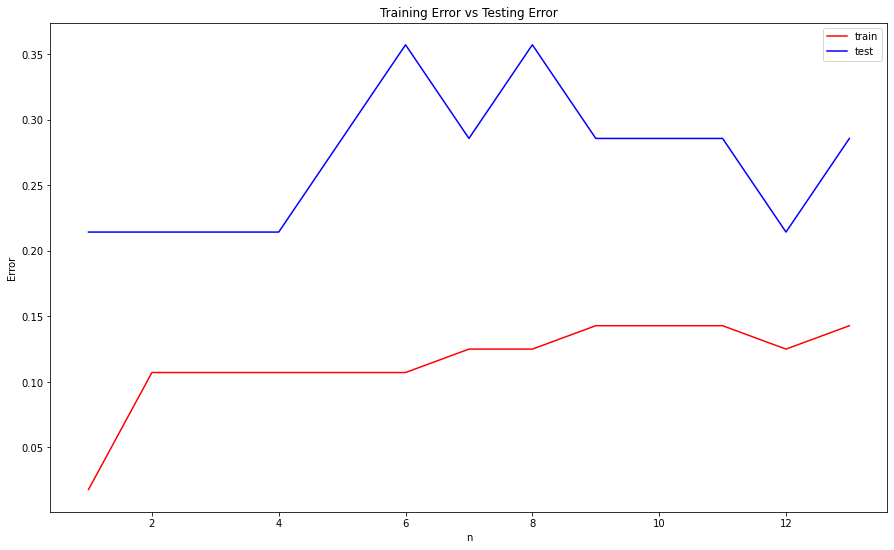

In [340]:
#main section to get the error and plot 

#df for storing error for seprate values of n
knn_error_df = pd.DataFrame(columns=["n", "test_error", "training_error"])

for i in range(1,14):
	y_train, y_train_predict, y_test, y_test_predict = knn_error(i, X_train, X_test, y_train, y_test)
	test_error = get_error(y_test, y_test_predict)
	train_error = get_error(y_train, y_train_predict)
	# test_error = 1-accuracy_score(y_test, y_test_predict)
	# train_error = 1-accuracy_score(y_train, y_train_predict)
	# test_error = mean_squared_error(y_test, y_test_predict)
	# train_error = mean_squared_error(y_train, y_train_predict)
	knn_error_df.loc[i-1] = [i,test_error,train_error]


#Plotting the training error and testing error for knn classification
plt.figure(figsize=(15,9))
plt.plot(knn_error_df.n,knn_error_df.training_error,label='train',color = 'r' )

plt.plot( knn_error_df.n,knn_error_df.test_error,label='test',color = 'b' )
plt.title("Training Error vs Testing Error")
plt.xlabel("n")
plt.ylabel("Error")
plt.legend()

---
---